In [1]:
import numpy as np 
import pandas as pd
# import scipy as sp
# from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [9]:
wd = "/Users/exequielpunzalan/EECS545/project/bigquery-geotab-intersection-congestion/data/data_to_use/test_size_0.2ofdata/"
sample_ratio = 0.03
# using my formatted train data
train_df = pd.read_csv(wd + "formatted_train_data_sampleratio{}.csv".format(sample_ratio))
train_labels_df = pd.read_csv(wd + "formatted_train_labels_sampleratio{}.csv".format(sample_ratio))
test_df = pd.read_csv(wd + "formatted_test_data_sampleratio{}.csv".format(sample_ratio))
test_labels_df = pd.read_csv(wd + "formatted_test_labels_sampleratio{}.csv".format(sample_ratio))
# drop categorical cols
categorical_cols = ['CityId','EntryHeading', 'ExitHeading', 'IntersectionId']
for col in categorical_cols:
    if col in train_df.columns:
        train_df = train_df.drop([col], axis=1)
        test_df = test_df.drop([col], axis=1)
# get labels
# labels = ["TotalTimeStopped_p20", "TotalTimeStopped_p50", "TotalTimeStopped_p80",
#           "DistanceToFirstStop_p20", "DistanceToFirstStop_p50", "DistanceToFirstStop_p80"]
labels = ["TotalTimeStopped_p20", "TotalTimeStopped_p50", "TotalTimeStopped_p80"]
X_train = train_df.to_numpy()
y_train = train_labels_df[labels].to_numpy()
X_test = test_df.to_numpy()
y_test = test_labels_df[labels].to_numpy()
print(train_df.shape)
print(test_df.shape)
print(y_train.shape)
print(y_test.shape)

(9534, 34)
(2387, 34)
(9534, 3)
(2387, 3)


In [10]:
# drop the least important features according to TotalTimeStopped_p20 relative importance plot
least_important_feats = ['HourlyDewPointTemperature', 'HourlyWetBulbTemperature', 'Month',
                         'CityId0', 'CityId1', 'CityId2']
train_df = train_df.drop(least_important_feats, axis=1)
test_df = test_df.drop(least_important_feats, axis=1)
X_train = train_df.to_numpy()
y_train = train_labels_df[labels].to_numpy()
X_test = test_df.to_numpy()
y_test = test_labels_df[labels].to_numpy()

In [11]:
# gradient boosting
best_params = {'estimator__criterion': 'mse',
               'estimator__learning_rate': 0.2,
               'estimator__max_depth': 3,
               'estimator__n_estimators': 100}
multigbm = MultiOutputRegressor(GradientBoostingRegressor())
multigbm.set_params(**best_params)
multigbm.fit(X_train, y_train)
# Predict on new data
y_multigbm = multigbm.predict(X_test)

In [14]:
# test MSE
y_pred0 = y_multigbm[:,0]
y_pred1 = y_multigbm[:,1]
y_pred2 = y_multigbm[:,2]
mse = mean_squared_error(y_test[:,0], y_multigbm[:,0])
mse1 = mean_squared_error(y_test[:,1], y_multigbm[:,1])
mse2 = mean_squared_error(y_test[:,2], y_multigbm[:,2])
# mse3 = mean_squared_error(y_test[:,3], y_multigbm[:,3])
# mse4 = mean_squared_error(y_test[:,4], y_multigbm[:,4])
# mse5 = mean_squared_error(y_test[:,5], y_multigbm[:,5])
rmse = mse**0.5
rmse1 = mse1**0.5
rmse2 = mse2**0.5
print(rmse, rmse1, rmse2)

7.3532871920764675 11.72934178806736 20.38447863490192


/Applications/anaconda/envs/EECS545-env/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


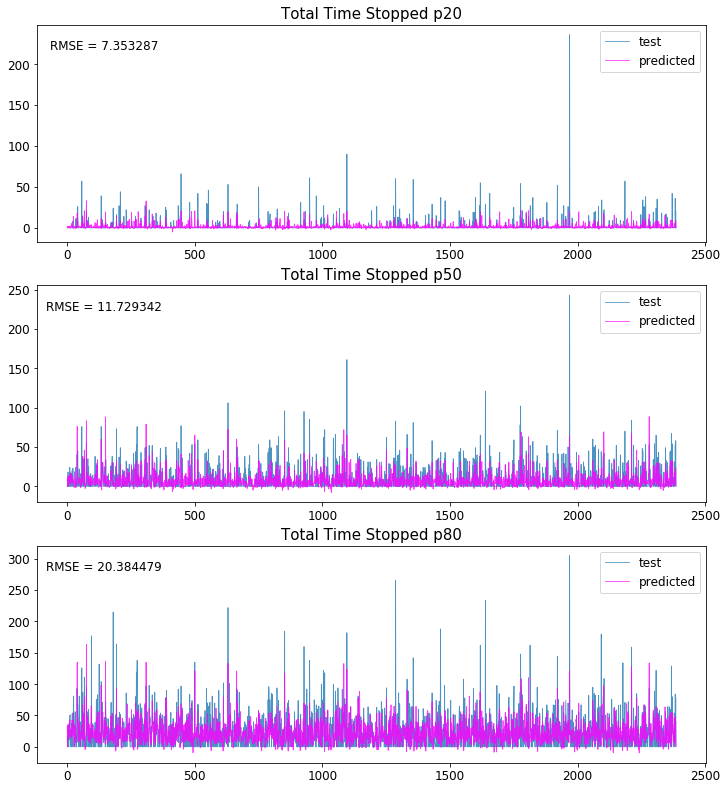

In [15]:
fig, axs = plt.subplots(3,1,figsize=(12,10))
axs[0].plot(y_test[:,0],label='test', linewidth=0.8,alpha=0.8)
axs[0].plot(y_pred0,label='predicted', linewidth=0.8,alpha=0.8,color='magenta')
axs[1].plot(y_test[:,1],label='test', linewidth=0.8,alpha=0.8)
axs[1].plot(y_pred1,label='predicted', linewidth=0.8,alpha=0.8,color='magenta')
axs[2].plot(y_test[:,2],label='test', linewidth=0.8,alpha=0.8)
axs[2].plot(y_pred2,label='predicted', linewidth=0.8,alpha=0.8,color='magenta')
axs[0].legend(loc =1,fontsize=12)
axs[1].legend(loc =1,fontsize=12)
axs[2].legend(loc =1,fontsize=12)
axs[0].tick_params(labelsize=12)
axs[1].tick_params(labelsize=12)
axs[2].tick_params(labelsize=12)
axs[0].set_title('Total Time Stopped p20',fontsize=15)
axs[1].set_title('Total Time Stopped p50',fontsize=15)
axs[2].set_title('Total Time Stopped p80',fontsize=15)
plt.text(0.1, 0.9,'RMSE = %f' %np.sqrt(mse), ha='center', va='center', transform=axs[0].transAxes,fontsize=12)
plt.text(0.1, 0.9,'RMSE = %f' %np.sqrt(mse1), ha='center', va='center', transform=axs[1].transAxes,fontsize=12)
plt.text(0.1, 0.9,'RMSE = %f' %np.sqrt(mse2), ha='center', va='center', transform=axs[2].transAxes,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(top=1.15)
plt.show()

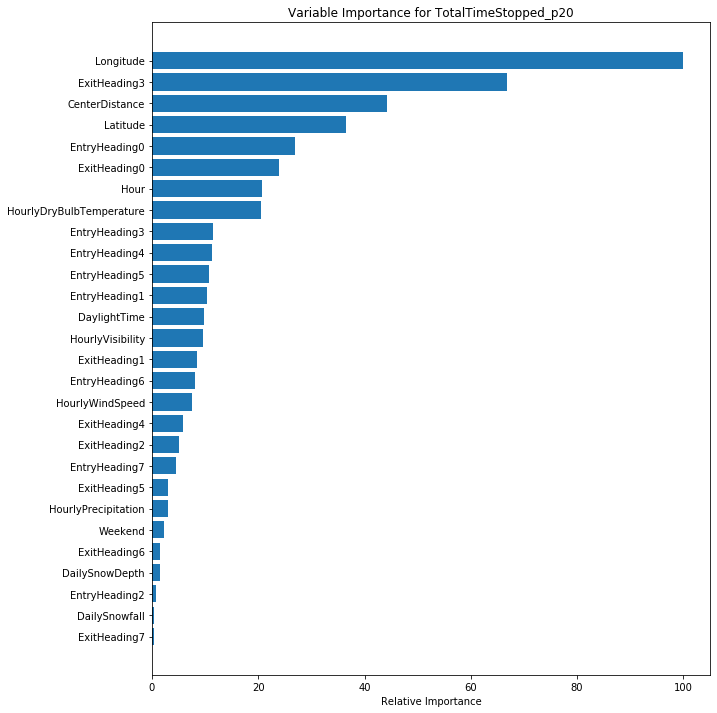

In [19]:
# Plot feature importance for TotalTimeStopped_p20

# dict of col indices as keys and names as values
cols_dict = {i: col_name for i, col_name in enumerate(train_df.columns)}

num_regressors = len(multigbm.estimators_)
regressors = []
feat_importances = [] # for each of the labels
for i in range(num_regressors):
    regressors.append(multigbm.estimators_[i])
    feat_importances.append(regressors[i].feature_importances_)
    
feature_importance = feat_importances[0]
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

# plotting
fig, ax = plt.subplots(figsize=(10,12))
ax.barh(y=pos, width=feature_importance[sorted_idx], align='center')
ax.set_yticks(pos)
# get column names
ax.set_yticklabels(np.array( [cols_dict[i] for i in sorted_idx] ))
ax.set_xlabel("Relative Importance")
ax.set_title("Variable Importance for TotalTimeStopped_p20")
plt.show()